In [1]:
import random
import math
import time
import pandas as pd
import numpy as np

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# 初期設定
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## 注意!!!!
**実行時はGPUを用いるが，サーバ上の空いているGPUを確認してから始めること**

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="9" #この数字がpytorchから見えるgpuの番号
#GPUが使えるかと使うことの明示
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

使用デバイス： cuda:0


In [4]:
from utils.dataloader import make_datapath_list,DataTransform, VOCDataset

#make file path lists
rootpath="./data/VOCdevkit/VOC2012/"
train_img_list,train_anno_list,val_img_list,val_anno_list=make_datapath_list(rootpath=rootpath)

#make Dataset
#normalize color_mean, color_std
color_mean=(0.485,0.456,0.406)
color_std=(0.229,0.224,0.225)

train_dataset=VOCDataset(train_img_list,train_anno_list,phase="train",transform=DataTransform(
    input_size=475,color_mean=color_mean,color_std=color_std))

val_dataset=VOCDataset(val_img_list,val_anno_list,phase="val",transform=DataTransform(
    input_size=475,color_mean=color_mean,color_std=color_std))

#make dataloader
batch_size=4 #pre 8, but GPU's memory size is limited.

train_dataloader=data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader=data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

#sumarize as dict
dataloaders_dict={"train":train_dataloader, "val":val_dataloader}

In [5]:
from utils.pspnet import PSPNet

#ファインチューニングでPSPNetを作成
#ADE20Kデータセットの学習済みモデルを使用，ADE20Kはクラス数が150
net=PSPNet(n_classes=150)

#ADE20K学習済みパラメタをロード
state_dict=torch.load("./weights/pspnet50_ADE20K.pth")
net.load_state_dict(state_dict)

#分類用の畳み込み層を，出力数21のものにする
n_classes=21
net.decode_feature.classification=nn.Conv2d(in_channels=512,out_channels=n_classes,kernel_size=1,stride=1,padding=0)
net.aux.classification=nn.Conv2d(in_channels=256,out_channels=n_classes,kernel_size=1,stride=1,padding=0)

#付け替えた畳み込み層を初期化．活性化関数がsigmoidなのでXavierを使用
def weights_init(m):
    if isinstance(m,nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias,0.0)
            
net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)

print('ネットワーク設定完了：学習済みの重みをロードしました．')

ネットワーク設定完了：学習済みの重みをロードしました．


In [6]:
#損失関数の設定
class PSPLoss(nn.Module):
    #PSPNetの損失関数のクラス
    
    def __init__(self,aux_weight=0.4):
        super(PSPLoss,self).__init__()
        self.aux_weight = aux_weight #auxlossの重み
        
    def forward(self,outputs,targets):
        """
        損失関数の計算
        
        Parameters
        outputs : PSPNetの出力(tuple)
            (output=torch.Size([num_batch,21,475,475]),output_aux=torch.Size([num_batch,21,475,475]))
        targets : [num_batch,475,475] 正解アノテーション情報
        
        Returns
        loss : Tensor 損失の値
        """
        
        loss=F.cross_entropy(outputs[0],targets,reduction='mean')
        loss_aux=F.cross_entropy(outputs[1],targets,reduction='mean')
        
        return loss+loss_aux*self.aux_weight
    
criterion=PSPLoss(aux_weight=0.4)

In [7]:
#ファインチューニングなので，学習率は小さく
optimizer=optim.SGD([
    {'params':net.feature_conv.parameters(), 'lr':1e-3},
    {'params':net.feature_res_1.parameters(), 'lr':1e-3},
    {'params':net.feature_res_2.parameters(), 'lr':1e-3},
    {'params':net.feature_dilated_res_1.parameters(), 'lr':1e-3},
    {'params':net.feature_dilated_res_2.parameters(), 'lr':1e-3},
    {'params':net.pyramid_pooling.parameters(), 'lr':1e-3},
    {'params':net.decode_feature.parameters(), 'lr':1e-2},
    {'params':net.aux.parameters(), 'lr':1e-2},
], momentum=0.9, weight_decay=0.0001)

#スケジューラーの設定
def lambda_epoch(epoch):
    max_epoch=30
    return math.pow((1-epoch/max_epoch), 0.9)

scheduler=optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

In [8]:
#モデルを学習させる関数を作成

def train_models(net,dataloaders_dict,criterion,scheduler,optimizer,num_epochs):
    
    #GPUが使えるかを確認
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：",device)
    
    #ネットワークをGPUへ
    net.to(device)
    
    #ネットワークがある程度固定であれば，高速化する
    torch.backends.cudnn.benchmark=True
    
    #画像の枚数
    num_train_imgs=len(dataloaders_dict["train"].dataset)
    num_val_imgs=len(dataloaders_dict["val"].dataset)
    batch_size=dataloaders_dict["train"].batch_size
    
    #イテレーションカウンタをセット
    iteration=1
    logs=[]
    
    #multiple minibatch
    batch_multiplier=3
    
    #epoch-loop
    for epoch in range(num_epochs):
        
        #start time
        t_epoch_start=time.time()
        t_iter_start=time.time()
        epoch_train_loss=0.0 #epochの損失和
        epoch_val_loss=0.0 #epochの損失和
        
        print('----------------')
        print('Epoch {}/{}'.format(epoch+1,num_epochs))
        print('----------------')
        
        #epochごとの訓練と検証のループ
        for phase in ['train','val']:
            if phase=='train':
                net.train()
                print(' (train) ')
                
            else:
                if((epoch+1)%5==0):
                    net.eval()
                    print('----------------')
                    print(' (val) ')
                else:
                    #検証は5回に1回
                    continue
                    
            #データローダからminibatchずつ取り出すループ
            count=0 #multiple minibatch
            for imges,anno_class_imges in dataloaders_dict[phase]:
                #ミニバッチのサイズが1だと，バッチノーマライゼーションでエラーになるので避ける
                if imges.size()[0]==1:
                    continue
                    
                #GPUが使えるならGPUにデータを送る
                imges=imges.to(device)
                anno_class_imges=anno_class_imges.to(device)
                
                #multiple minibatchでのパラメタ更新
                if(phase=='train') and (count==0):
                    optimizer.step()
                    optimizer.zero_grad()
                    count=batch_multiplier
                    
                #順伝搬計算
                with torch.set_grad_enabled(phase=='train'):
                    outputs=net(imges)
                    loss=criterion(outputs,anno_class_imges.long()) / batch_multiplier
                    
                    #訓練時はback-prop
                    if phase=='train':
                        loss.backward() #勾配の計算
                        count-=1 #multiple minibatch
                        
                        if (iteration%10==0): #10iterに1度，lossを表示
                            t_iter_finishi=time.time()
                            duration=t_iter_finishi-t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec'.format(
                                 iteration, loss.item()/batch_size*batch_multiplier,duration))
                            t_iter_start=time.time()
                            
                        epoch_train_loss+=loss.item()*batch_multiplier
                        iteration+=1
                        
                    #検証時
                    else:
                        epoch_val_loss+=loss.item()*batch_multiplier
            
            if phase=='train':
                scheduler.step() #最適化schedulerの更新
                optimizer.zero_grad()
                    
        #epochのphaseごとのlossと正解率
        t_epoch_finishi=time.time()
        print('----------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1,epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
        print('timer: {:.4f} sec.'.format(t_epoch_finishi-t_epoch_start))
        t_epoch_start=time.time()

        #ログを保存
        log_epoch={'epoch':epoch,'train_loss':epoch_train_loss/num_train_imgs,'val_loss':epoch_val_loss/num_val_imgs}
        logs.append(log_epoch)
        df=pd.DataFrame(logs)
        df.to_csv("log_output.csv")
                
    #最後のネットワークを保存する
    torch.save(net.state_dict(),'weights/pspnet_finetuning50_'+str(epoch+1)+'pth')            

In [9]:
#学習・検証を実行する
num_epochs=30
train_models(net,dataloaders_dict,criterion,scheduler,optimizer,num_epochs=num_epochs)

使用デバイス： cuda:0
----------------
Epoch 1/30
----------------
 (train) 
イテレーション 10 || Loss: 0.8783 || 10iter: 14.1487 sec
イテレーション 20 || Loss: 0.6197 || 10iter: 7.4104 sec
イテレーション 30 || Loss: 0.6896 || 10iter: 7.2257 sec
イテレーション 40 || Loss: 0.7818 || 10iter: 6.9561 sec
イテレーション 50 || Loss: 0.4151 || 10iter: 7.0157 sec
イテレーション 60 || Loss: 0.3042 || 10iter: 7.1713 sec
イテレーション 70 || Loss: 0.3218 || 10iter: 6.9888 sec
イテレーション 80 || Loss: 0.1601 || 10iter: 6.9400 sec
イテレーション 90 || Loss: 0.8410 || 10iter: 7.0196 sec
イテレーション 100 || Loss: 0.4947 || 10iter: 7.1226 sec
イテレーション 110 || Loss: 0.2521 || 10iter: 7.1411 sec
イテレーション 120 || Loss: 0.2730 || 10iter: 7.2437 sec
イテレーション 130 || Loss: 0.2188 || 10iter: 7.2987 sec
イテレーション 140 || Loss: 0.2042 || 10iter: 7.0654 sec
イテレーション 150 || Loss: 0.3068 || 10iter: 6.8928 sec
イテレーション 160 || Loss: 0.4011 || 10iter: 6.9849 sec
イテレーション 170 || Loss: 0.4531 || 10iter: 7.3866 sec
イテレーション 180 || Loss: 0.1960 || 10iter: 7.1521 sec
イテレーション 190 || Loss: 0.1407 || 10iter:

イテレーション 1680 || Loss: 0.0897 || 10iter: 7.1103 sec
イテレーション 1690 || Loss: 0.2021 || 10iter: 7.2637 sec
イテレーション 1700 || Loss: 0.0675 || 10iter: 7.0832 sec
イテレーション 1710 || Loss: 0.1166 || 10iter: 7.1699 sec
イテレーション 1720 || Loss: 0.1114 || 10iter: 7.0810 sec
イテレーション 1730 || Loss: 0.0782 || 10iter: 7.1268 sec
イテレーション 1740 || Loss: 0.0849 || 10iter: 7.0002 sec
イテレーション 1750 || Loss: 0.1475 || 10iter: 7.1339 sec
イテレーション 1760 || Loss: 0.1114 || 10iter: 7.1793 sec
イテレーション 1770 || Loss: 0.0866 || 10iter: 7.3770 sec
イテレーション 1780 || Loss: 0.0618 || 10iter: 7.1052 sec
イテレーション 1790 || Loss: 0.0765 || 10iter: 7.2605 sec
イテレーション 1800 || Loss: 0.0949 || 10iter: 6.8431 sec
イテレーション 1810 || Loss: 0.1516 || 10iter: 6.8809 sec
イテレーション 1820 || Loss: 0.1582 || 10iter: 7.3177 sec
イテレーション 1830 || Loss: 0.3750 || 10iter: 7.2078 sec
----------------
 (val) 
----------------
epoch 5 || Epoch_TRAIN_Loss:0.1325 ||Epoch_VAL_Loss:0.1646
timer: 384.7388 sec.
----------------
Epoch 6/30
----------------
 (train) 
イテレーション

イテレーション 3170 || Loss: 0.0661 || 10iter: 7.1440 sec
イテレーション 3180 || Loss: 0.1179 || 10iter: 6.8923 sec
イテレーション 3190 || Loss: 0.1178 || 10iter: 7.4055 sec
イテレーション 3200 || Loss: 0.1135 || 10iter: 7.2903 sec
イテレーション 3210 || Loss: 0.1493 || 10iter: 7.2440 sec
イテレーション 3220 || Loss: 0.0380 || 10iter: 7.1075 sec
イテレーション 3230 || Loss: 0.0710 || 10iter: 7.1811 sec
イテレーション 3240 || Loss: 0.0821 || 10iter: 7.1259 sec
イテレーション 3250 || Loss: 0.1841 || 10iter: 7.1027 sec
イテレーション 3260 || Loss: 0.0873 || 10iter: 7.0361 sec
イテレーション 3270 || Loss: 0.0705 || 10iter: 7.2485 sec
イテレーション 3280 || Loss: 0.1156 || 10iter: 6.9351 sec
イテレーション 3290 || Loss: 0.0966 || 10iter: 7.0888 sec
----------------
epoch 9 || Epoch_TRAIN_Loss:0.1127 ||Epoch_VAL_Loss:0.0000
timer: 283.6531 sec.
----------------
Epoch 10/30
----------------
 (train) 
イテレーション 3300 || Loss: 0.1585 || 10iter: 4.1631 sec
イテレーション 3310 || Loss: 0.1529 || 10iter: 7.2602 sec
イテレーション 3320 || Loss: 0.0488 || 10iter: 7.3042 sec
イテレーション 3330 || Loss: 0.1227 ||

イテレーション 4660 || Loss: 0.1192 || 10iter: 7.2345 sec
イテレーション 4670 || Loss: 0.0735 || 10iter: 7.0134 sec
イテレーション 4680 || Loss: 0.0438 || 10iter: 7.3763 sec
イテレーション 4690 || Loss: 0.0381 || 10iter: 7.4122 sec
イテレーション 4700 || Loss: 0.0641 || 10iter: 7.4293 sec
イテレーション 4710 || Loss: 0.0398 || 10iter: 6.8909 sec
イテレーション 4720 || Loss: 0.1120 || 10iter: 7.6139 sec
イテレーション 4730 || Loss: 0.0403 || 10iter: 7.0634 sec
イテレーション 4740 || Loss: 0.0852 || 10iter: 7.2265 sec
イテレーション 4750 || Loss: 0.0910 || 10iter: 7.3509 sec
----------------
epoch 13 || Epoch_TRAIN_Loss:0.0920 ||Epoch_VAL_Loss:0.0000
timer: 285.7078 sec.
----------------
Epoch 14/30
----------------
 (train) 
イテレーション 4760 || Loss: 0.0611 || 10iter: 0.9720 sec
イテレーション 4770 || Loss: 0.0680 || 10iter: 7.5811 sec
イテレーション 4780 || Loss: 0.0761 || 10iter: 7.5027 sec
イテレーション 4790 || Loss: 0.0525 || 10iter: 7.3752 sec
イテレーション 4800 || Loss: 0.1392 || 10iter: 7.3573 sec
イテレーション 4810 || Loss: 0.2510 || 10iter: 7.3764 sec
イテレーション 4820 || Loss: 0.0207 |

イテレーション 6150 || Loss: 0.0645 || 10iter: 7.1244 sec
イテレーション 6160 || Loss: 0.0953 || 10iter: 7.3263 sec
イテレーション 6170 || Loss: 0.0435 || 10iter: 7.1159 sec
イテレーション 6180 || Loss: 0.0574 || 10iter: 7.0008 sec
イテレーション 6190 || Loss: 0.0192 || 10iter: 7.3597 sec
イテレーション 6200 || Loss: 0.0752 || 10iter: 7.2032 sec
イテレーション 6210 || Loss: 0.1014 || 10iter: 7.2379 sec
イテレーション 6220 || Loss: 0.0547 || 10iter: 7.0380 sec
----------------
epoch 17 || Epoch_TRAIN_Loss:0.0855 ||Epoch_VAL_Loss:0.0000
timer: 284.4846 sec.
----------------
Epoch 18/30
----------------
 (train) 
イテレーション 6230 || Loss: 0.0426 || 10iter: 5.6733 sec
イテレーション 6240 || Loss: 0.0209 || 10iter: 7.2753 sec
イテレーション 6250 || Loss: 0.1536 || 10iter: 7.2827 sec
イテレーション 6260 || Loss: 0.0589 || 10iter: 7.1912 sec
イテレーション 6270 || Loss: 0.0482 || 10iter: 7.4536 sec
イテレーション 6280 || Loss: 0.0718 || 10iter: 7.5661 sec
イテレーション 6290 || Loss: 0.0315 || 10iter: 7.2539 sec
イテレーション 6300 || Loss: 0.0570 || 10iter: 7.2124 sec
イテレーション 6310 || Loss: 0.0922 |

イテレーション 7640 || Loss: 0.0574 || 10iter: 7.2947 sec
イテレーション 7650 || Loss: 0.0424 || 10iter: 7.1531 sec
イテレーション 7660 || Loss: 0.0749 || 10iter: 7.1492 sec
イテレーション 7670 || Loss: 0.0865 || 10iter: 7.3469 sec
イテレーション 7680 || Loss: 0.1190 || 10iter: 7.2790 sec
----------------
epoch 21 || Epoch_TRAIN_Loss:0.0821 ||Epoch_VAL_Loss:0.0000
timer: 284.1916 sec.
----------------
Epoch 22/30
----------------
 (train) 
イテレーション 7690 || Loss: 0.0943 || 10iter: 2.4894 sec
イテレーション 7700 || Loss: 0.0513 || 10iter: 7.0837 sec
イテレーション 7710 || Loss: 0.0824 || 10iter: 7.1554 sec
イテレーション 7720 || Loss: 0.1004 || 10iter: 7.1191 sec
イテレーション 7730 || Loss: 0.1656 || 10iter: 7.3700 sec
イテレーション 7740 || Loss: 0.0347 || 10iter: 7.2660 sec
イテレーション 7750 || Loss: 0.1001 || 10iter: 7.3810 sec
イテレーション 7760 || Loss: 0.0555 || 10iter: 6.9762 sec
イテレーション 7770 || Loss: 0.0745 || 10iter: 7.3947 sec
イテレーション 7780 || Loss: 0.0529 || 10iter: 7.2938 sec
イテレーション 7790 || Loss: 0.0477 || 10iter: 7.1638 sec
イテレーション 7800 || Loss: 0.0776 |

イテレーション 9130 || Loss: 0.0213 || 10iter: 7.2959 sec
イテレーション 9140 || Loss: 0.0706 || 10iter: 6.9678 sec
イテレーション 9150 || Loss: 0.0648 || 10iter: 7.2941 sec
----------------
 (val) 
----------------
epoch 25 || Epoch_TRAIN_Loss:0.0792 ||Epoch_VAL_Loss:0.1445
timer: 383.7728 sec.
----------------
Epoch 26/30
----------------
 (train) 
イテレーション 9160 || Loss: 0.0368 || 10iter: 7.3328 sec
イテレーション 9170 || Loss: 0.0648 || 10iter: 7.1076 sec
イテレーション 9180 || Loss: 0.1868 || 10iter: 7.1194 sec
イテレーション 9190 || Loss: 0.0462 || 10iter: 7.1363 sec
イテレーション 9200 || Loss: 0.0580 || 10iter: 7.4638 sec
イテレーション 9210 || Loss: 0.2849 || 10iter: 7.1284 sec
イテレーション 9220 || Loss: 0.0499 || 10iter: 6.8754 sec
イテレーション 9230 || Loss: 0.0571 || 10iter: 7.1724 sec
イテレーション 9240 || Loss: 0.0453 || 10iter: 7.3760 sec
イテレーション 9250 || Loss: 0.0306 || 10iter: 7.1409 sec
イテレーション 9260 || Loss: 0.1057 || 10iter: 7.0927 sec
イテレーション 9270 || Loss: 0.0707 || 10iter: 7.0861 sec
イテレーション 9280 || Loss: 0.0390 || 10iter: 7.4961 sec
イテレーシ

イテレーション 10600 || Loss: 0.0794 || 10iter: 7.1147 sec
イテレーション 10610 || Loss: 0.0271 || 10iter: 7.3362 sec
----------------
epoch 29 || Epoch_TRAIN_Loss:0.0758 ||Epoch_VAL_Loss:0.0000
timer: 284.9708 sec.
----------------
Epoch 30/30
----------------
 (train) 
イテレーション 10620 || Loss: 0.0922 || 10iter: 4.1916 sec
イテレーション 10630 || Loss: 0.0304 || 10iter: 7.4997 sec
イテレーション 10640 || Loss: 0.0284 || 10iter: 7.4383 sec
イテレーション 10650 || Loss: 0.0500 || 10iter: 7.1118 sec
イテレーション 10660 || Loss: 0.1361 || 10iter: 7.3795 sec
イテレーション 10670 || Loss: 0.1065 || 10iter: 7.0384 sec
イテレーション 10680 || Loss: 0.0446 || 10iter: 7.3592 sec
イテレーション 10690 || Loss: 0.0885 || 10iter: 7.5054 sec
イテレーション 10700 || Loss: 0.0414 || 10iter: 7.2396 sec
イテレーション 10710 || Loss: 0.1534 || 10iter: 7.3668 sec
イテレーション 10720 || Loss: 0.0295 || 10iter: 7.3304 sec
イテレーション 10730 || Loss: 0.0522 || 10iter: 7.0533 sec
イテレーション 10740 || Loss: 0.1722 || 10iter: 7.3128 sec
イテレーション 10750 || Loss: 0.0339 || 10iter: 7.2538 sec
イテレーション 10760 

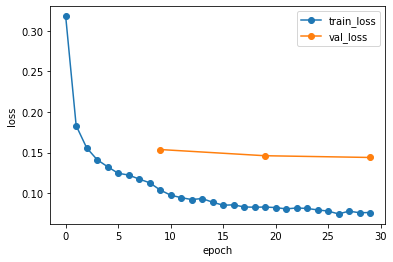

In [10]:
import matplotlib.pyplot as plt
 
#CSVファイルをUTF-8形式で読み込む
data = pd.read_csv('log_output.csv',encoding = 'UTF8')
#dataを出力
plt.plot(data['epoch'],data['train_loss'], marker='o', label='train_loss')
plt.plot(data['epoch'][9:50:10],data['val_loss'][9:50:10], marker='o',label="val_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()